The Product reviews full score dataset is constructed by randomly taking 600,000 training samples and 130,000 testing samples for each review score from 1 to 5. In total there are 3,000,000 trainig samples and 650,000 testing samples.

Dataset link: https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ

Kaggle link: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/data

In [2]:
import re
import nltk
import pickle
import pandas as pd
import numpy as np
import requests
import joblib

In [3]:
# Data processing
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer # type: ignore

In [5]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [6]:
# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [7]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from PIL import Image
from wordcloud import WordCloud,  ImageColorGenerator

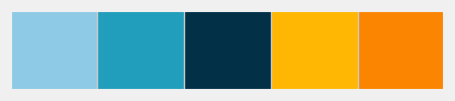

In [8]:
style.use("fivethirtyeight")
colors = ["#8ecae6", "#219ebc", "#023047", "#ffb703", "#fb8500"]
palette = sns.color_palette(colors)
sns.palplot(sns.color_palette(colors))
plt.show()
style.use("fivethirtyeight")

#### **Importing the Dataset:**

In [9]:
url = 'https://raw.githubusercontent.com/m-wasim/Amazon_review_analysis/main/train.csv'
data = pd.read_csv(url)
url2 = 'https://raw.githubusercontent.com/Kimola/nlp-datasets/main/amazon-product-reviews/Apple%20AirTag%20(Technology)%20-%20Amazon%20Product%20Reviews.csv'
data2 = pd.read_csv(url2)
data.head(10)
#data2.head(10)

,Id,rating,date,variation,verified_reviews,feedback
0,1916,5,26-Jul-18,White Plus,I love it. Use it mostly for the music huge re...,1
1,500,5,24-Jun-18,Black,There's really no dislike for Alexa( dot) I th...,1
2,2958,5,30-Jul-18,Black Dot,I love searching the Alexa skill shop on the a...,1
3,1968,5,25-Jul-18,White Plus,I love my Echo Plus and have cousins from Ital...,1
4,156,4,30-Jul-18,Charcoal Fabric,i have not found a way to access my echo thoro...,1
5,83,5,30-Jul-18,Heather Gray Fabric,I purchased an echo dot for my husband for Fat...,1
6,2973,4,30-Jul-18,Black Dot,I'm amazed with the alarm. I tell Alexa to wak...,1
7,579,1,10-Jun-18,Black,"great product, but useless overall. Too many u...",0
8,176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0
9,1964,5,25-Jul-18,Black Plus,This is a very useful device. I use it to tur...,1


In [10]:
import pandas as pd

df = pd.read_csv("../amazon_review_full_csv/train.csv", header=None)
df.head(10)

,0,1,2
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even..."
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,4,"Errors, but great story",I was a dissapointed to see errors on the back...
8,1,The Worst!,A complete waste of time. Typographical errors...
9,1,Oh please,I guess you have to be a romance novel lover f...


In [11]:

df.shape

(3000000, 3)

#### **Modifying the Dataset:**

We first name the columns as "Rating", "Title" and "Review".

In [12]:
data = data[['rating', 'variation', 'verified_reviews']]
data.columns = ['Rating', 'Title', 'Review']
print(data.head(10))

   Rating                 Title  \
0       5           White  Plus   
1       5                 Black   
2       5            Black  Dot   
3       5           White  Plus   
4       4      Charcoal Fabric    
5       5  Heather Gray Fabric    
6       4            Black  Dot   
7       1                 Black   
8       2  Heather Gray Fabric    
9       5           Black  Plus   

                                              Review  
0  I love it. Use it mostly for the music huge re...  
1  There's really no dislike for Alexa( dot) I th...  
2  I love searching the Alexa skill shop on the a...  
3  I love my Echo Plus and have cousins from Ital...  
4  i have not found a way to access my echo thoro...  
5  I purchased an echo dot for my husband for Fat...  
6  I'm amazed with the alarm. I tell Alexa to wak...  
7  great product, but useless overall. Too many u...  
8                               Sad joke. Worthless.  
9  This is a very useful device.  I use it to tur...  


We then combine the "Review" and "Title" column into one, as it should not contradict the overall sentiment.

In [13]:
df = df[[0,1,2]]
df.columns = ['Rating', 'Title', 'Review']
print(df.head(10))

   Rating                                  Title  \
0       3                     more like funchuck   
1       5                              Inspiring   
2       5  The best soundtrack ever to anything.   
3       4                       Chrono Cross OST   
4       5                    Too good to be true   
5       5         There's a reason for the price   
6       1                           Buyer beware   
7       4                Errors, but great story   
8       1                             The Worst!   
9       1                              Oh please   

                                              Review  
0  Gave this to my dad for a gag gift after direc...  
1  I hope a lot of people hear this cd. We need m...  
2  I'm reading a lot of reviews saying that this ...  
3  The music of Yasunori Misuda is without questi...  
4  Probably the greatest soundtrack in history! U...  
5  There's a reason this CD is so expensive, even...  
6  This is a self-published book, and if y

In [14]:
df["Review"] = df["Title"] + " " + df["Review"]
df = df[['Review', 'Rating']]
df.head()

,Review,Rating
0,more like funchuck Gave this to my dad for a g...,3
1,Inspiring I hope a lot of people hear this cd....,5
2,The best soundtrack ever to anything. I'm read...,5
3,Chrono Cross OST The music of Yasunori Misuda ...,4
4,Too good to be true Probably the greatest soun...,5


The sentiment to each review is added by considering a rating above 3 as "Positive", below 3 as "Negative" and equal to 3 as "Neutral".

In [15]:
def sentiment(label):
    if label<3:
        return "Negative"
    elif label>3:
        return "Positive"
    else:
        return "Neutral"

In [16]:
df['Sentiment'] = df["Rating"].apply(sentiment)
df.head(10)

,Review,Rating,Sentiment
0,more like funchuck Gave this to my dad for a g...,3,Neutral
1,Inspiring I hope a lot of people hear this cd....,5,Positive
2,The best soundtrack ever to anything. I'm read...,5,Positive
3,Chrono Cross OST The music of Yasunori Misuda ...,4,Positive
4,Too good to be true Probably the greatest soun...,5,Positive
5,There's a reason for the price There's a reaso...,5,Positive
6,"Buyer beware This is a self-published book, an...",1,Negative
7,"Errors, but great story I was a dissapointed t...",4,Positive
8,The Worst! A complete waste of time. Typograph...,1,Negative
9,Oh please I guess you have to be a romance nov...,1,Negative


#### **Data Analysis:**

In [17]:
df.shape

(3000000, 3)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Review     object
 1   Rating     int64 
 2   Sentiment  object
dtypes: int64(1), object(2)
memory usage: 68.7+ MB


In [19]:
df.value_counts("Rating")

Rating
1    600000
2    600000
3    600000
4    600000
5    600000
Name: count, dtype: int64

In [20]:
df.value_counts("Sentiment")

Sentiment
Negative    1200000
Positive    1200000
Neutral      600000
Name: count, dtype: int64

C:\Users\vedant\AppData\Local\Temp\ipykernel_25308\1000734209.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=df,  palette=["#f8de7e","#32fa53",'#fa3232'])


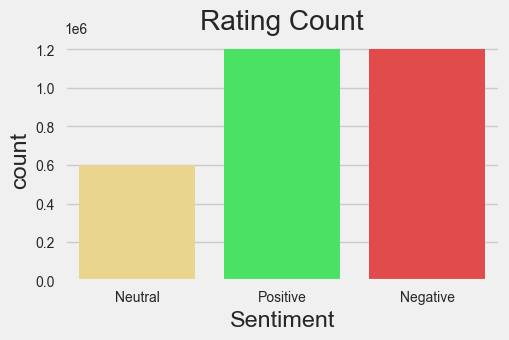

In [21]:
plt.figure(figsize=(5,3))
sns.countplot(x="Sentiment", data=df,  palette=["#f8de7e","#32fa53",'#fa3232'])
plt.title("Rating Count")
plt.show()

In [22]:
df["Rating"].value_counts()/len(df)

Rating
3    0.2
5    0.2
4    0.2
1    0.2
2    0.2
Name: count, dtype: float64

In [23]:
df["Sentiment"].value_counts()/len(df)

Sentiment
Positive    0.4
Negative    0.4
Neutral     0.2
Name: count, dtype: float64

In [24]:
df.isna().sum()

Review       188
Rating         0
Sentiment      0
dtype: int64

We can see that there are no null values in Ratings or Sentiments, so we do not have to drop any rows.
However, there are 188 rows that are empty, so we fill it with an empty string.

In [25]:
df = df.fillna(' ')
df.isna().sum()

Review       0
Rating       0
Sentiment    0
dtype: int64

**Number of characters present in each Review:**

Here I range the number of characters by 500 chars and so on.

In [26]:
text_len = df['Review'].groupby(pd.cut(df['Review'].str.len(), np.arange(0, 20000+500, 500))).count().rename_axis(['Range']).reset_index()
text_len.head()

C:\Users\vedant\AppData\Local\Temp\ipykernel_25308\1233979845.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  text_len = df['Review'].groupby(pd.cut(df['Review'].str.len(), np.arange(0, 20000+500, 500))).count().rename_axis(['Range']).reset_index()


,Range,Review
0,"(0, 500]",1911735
1,"(500, 1000]",1071380
2,"(1000, 1500]",16885
3,"(1500, 2000]",0
4,"(2000, 2500]",0


In [27]:
text_len_50 = text_len[text_len['Review'] > 50]
text_len_50

,Range,Review
0,"(0, 500]",1911735
1,"(500, 1000]",1071380
2,"(1000, 1500]",16885


C:\Users\vedant\AppData\Local\Temp\ipykernel_25308\4000903183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\vedant\AppData\Local\Temp\ipykernel_25308\4000903183.py:2: UserWarning: 
The palette list has fewer values (5) than needed (40) and will cycle, which may produce an uninterpretable plot.
  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\vedant\AppData\Local\Temp\ipykernel_25308\4000903183.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


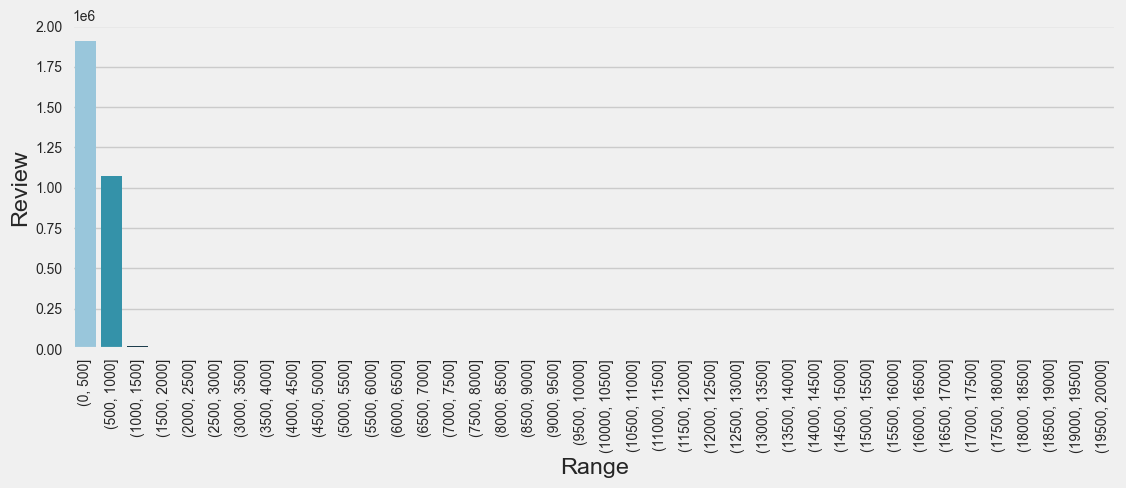

In [28]:
plt.figure(figsize=(12, 4))
g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

C:\Users\vedant\AppData\Local\Temp\ipykernel_25308\4267152122.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=df['Review'].str.len(), palette=palette)


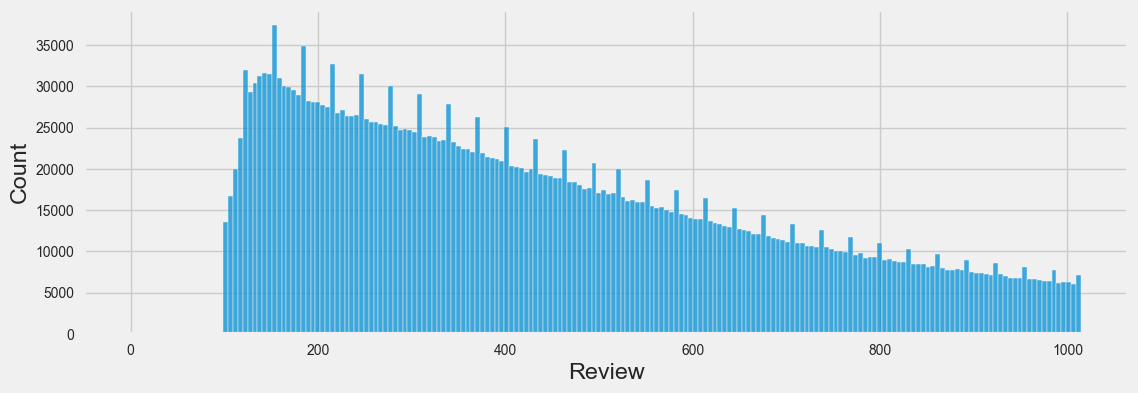

In [29]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x=df['Review'].str.len(), palette=palette)
plt.show()

#### **Sampling the data:**
Since there are over 35 million reviews in this dataset, we will only use a portion of this for training our models. We will use Stratified Shuffle Split for this.

Benefits of StratifiedShuffleSplit:

- Maintains class balance: This is crucial for sentiment analysis where you have different classes representing positive, negative, and neutral reviews. Stratified sampling ensures the sampled data reflects the same proportion of each class as your original dataset, preventing biases in your model's training.
- Reduces computational cost: Training on a smaller sample is significantly faster and less resource-intensive compared to using the entire dataset.
- Provides representative data: Stratified sampling ensures the selected data is representative of the entire population, leading to a more robust and generalizable model.

In [30]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.97)
for train_index, test_index in split.split(df, df["Sentiment"]): 
    strat_data = df.reindex(train_index)

In [31]:
strat_data.head(10)

,Review,Rating,Sentiment
1816444,"it works very well, but you will still not be ...",5,Positive
1810921,Creative drives do not work with Dell and Wind...,3,Neutral
1134129,A wonderful reading experience for all Christi...,5,Positive
1862597,A New Day Has Come! I was very pleased to hear...,5,Positive
644141,The StiffUpperLips make good sci-fi. Thanks bl...,4,Positive
1648877,Graduation The only song on this CD that I've ...,4,Positive
248678,snowboard academy This would have to be one of...,1,Negative
2595807,i do not recommend I bought this for my canon ...,2,Negative
1605577,"Gain some, lose some I love this record and wh...",4,Positive
1764379,"perfect It was just as described, new and unus...",5,Positive


We take a sample dataset of 90000 rows.

In [32]:
strat_data.shape

(90000, 3)

In [33]:
strat_data.value_counts("Sentiment")

Sentiment
Negative    36000
Positive    36000
Neutral     18000
Name: count, dtype: int64

#### **Cleaning data:**

Cleaning data includes

- Tokenization: Tokenization is the process of converting text into tokens before transforming it into vectors. 
- Stop Words Removal: Stop words are the most commonly occuring words which are not relevant in the context of the data and do not contribute any deeper meaning to the phrase. 
- Normalization: Words which look different due to casing or written another way but are the same in meaning need to be process correctly. Normalisation processes ensure that these words are treated equally. This includes:
    - Casing the characters: Converting character to the same case so the same words are recognised as the same. In this case we converted to lowercase
    - Negation Handling
- Lemmetization: This process finds the base or dictionary form of the word known as the lemma.

In [34]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vedant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
def preprocess_text(text):
    # Make text lowercase and remove links, text in square brackets, punctuation, and words containing numbers
    text = str(text)
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*', ' ', text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lem_tokens)

For example:

In [36]:
preprocess_text(df["Review"][2])

'best soundtrack ever anything reading lot review saying best game soundtrack figured write review disagree bit opinino yasunori mitsuda ultimate masterpiece music timeless listening year beauty simply refuse fade price tag pretty staggering must say going buy cd much money one feel would worth every penny'

In [37]:
preprocess_text(df["Review"][110])

'fabulous book completely instrumental guiding husband timberframing pursuit read much cover binding fallen broken hold best reference diyer look starting structure'

We do the same for all the reviews in the dataset.

In [38]:
strat_data["Review"] = strat_data["Review"].apply(preprocess_text)
strat_data.head(10)

,Review,Rating,Sentiment
1816444,work well still numb degree numbing would get ...,5,Positive
1810921,creative drive work dell window known issue cr...,3,Neutral
1134129,wonderful reading experience christian loved r...,5,Positive
1862597,new day come pleased hear celine dion would re...,5,Positive
644141,stiffupperlips make good sci fi thanks bloke t...,4,Positive
1648877,graduation song cd heard graduation grade grad...,4,Positive
248678,snowboard academy would one worst movie corey ...,1,Negative
2595807,recommend bought canon vixia hf better sound q...,2,Negative
1605577,gain lose love record nice four remixes sleepy...,4,Positive
1764379,perfect described new unused child loved endin...,5,Positive


#### **Word Cloud:**

In [39]:
txt = "".join(strat_data["Review"].tolist())

In [40]:
len(txt)

24037666

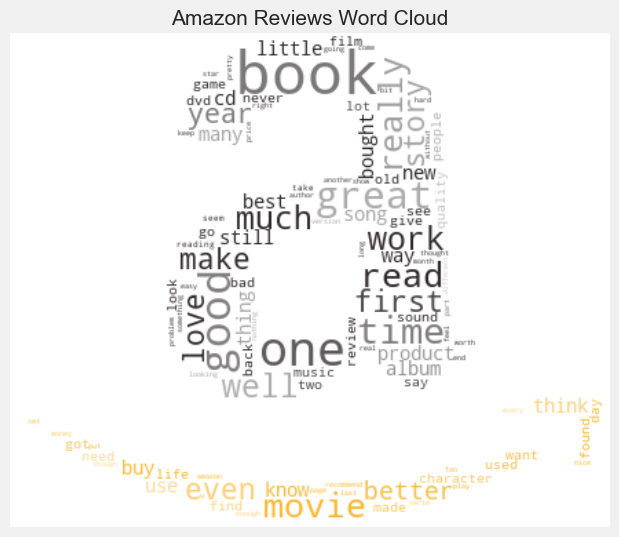

In [41]:
amazon_mask = np.array(Image.open(requests.get('https://pngimg.com/uploads/amazon/amazon_PNG4.png', stream=True).raw))

wc = WordCloud(width = 300, height = 200, random_state=1, background_color='white', colormap='Set2', collocations=False, mask=amazon_mask).generate(txt)
image_colors = ImageColorGenerator(amazon_mask)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc, interpolation='bilinear')
plt.title("Amazon Reviews Word Cloud", fontsize = 15)
plt.savefig('wordcloud.png')
plt.show()

#### **Vectorization:**

**Count Vectorization:**

Count vectoriser transforms a given text into a vector on the basis of the frequency of each word that occurs in the entire text. It is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors

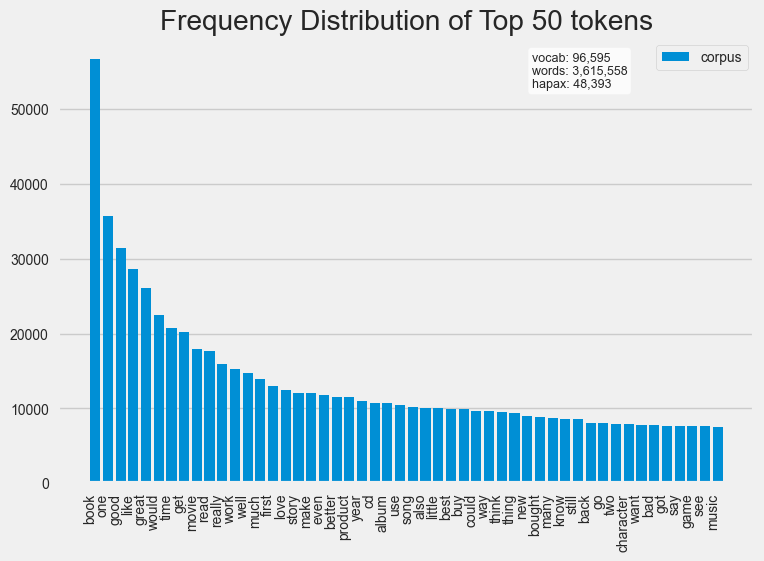

In [42]:
def word_distribution(text):
    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names_out()
    
    # Freq Dist Visualizer
    visualizer = FreqDistVisualizer(features=features, orient='v')
    visualizer.fit(docs)
    visualizer.show()

word_distribution(strat_data['Review'])

**TF-IDF Vectorizer:**

Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF).

- The term frequency is the number of occurrences of a specific term in a document. Term frequency indicates how important a specific term in a document. Term frequency represents every text from the data as a matrix whose rows are the number of documents and columns are the number of distinct terms throughout all documents.

- Document frequency is the number of documents containing a specific term. Document frequency indicates how common the term is.Inverse document frequency (IDF) is the weight of a term, it aims to reduce the weight of a term if the term’s occurrences are scattered throughout all the documents. 

In [43]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1,3))

In [44]:
X_tfidf = tfidf_vectorizer.fit_transform(strat_data['Review'])
X_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2800092 stored elements and shape (90000, 5000)>

In [45]:
X_tfidf.shape

(90000, 5000)

In [46]:
y = strat_data["Sentiment"]

In [47]:
y.shape

(90000,)

### **Training the model using Logistic Regression**

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42,test_size = 0.20)

In [49]:
print(X_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(X_test.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_test.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")

(72000, 5000)
Number of Training Samples: 72000
(72000,)
Number of Training Samples: 72000
(18000, 5000)
Number of Training Samples: 72000
(18000,)
Number of Training Samples: 72000


In [50]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=4000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=4000)

In [51]:
predictedLogReg = logreg.predict(X_test)
np.mean(predictedLogReg == y_test)

np.float64(0.7112222222222222)

In [52]:
inp_test = input("Enter review: ")
print(inp_test)

inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)

inp_test = tfidf_vectorizer.transform([inp_test])
logreg.predict(inp_test)

While the product arrived earlier than expected and the packaging was impressive, the actual build quality left much to be desired, especially considering the premium price point — I found myself both impressed by the service and disappointed by the performance.
After preprocessing:  product arrived earlier expected packaging impressive actual build quality left much desired especially considering premium price point found impressed service disappointed performance


array(['Negative'], dtype=object)

#### **Model Analysis:**

In [53]:
# classification_report and accuracy_score using sklearn.metrics library
print("Classification Report")
print(f"{classification_report(y_test, predictedLogReg)}")
print(f"Accuracy: {accuracy_score(y_test, predictedLogReg)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.73      0.81      0.77      7230
     Neutral       0.48      0.28      0.35      3548
    Positive       0.75      0.83      0.79      7222

    accuracy                           0.71     18000
   macro avg       0.65      0.64      0.64     18000
weighted avg       0.69      0.71      0.69     18000

Accuracy: 0.7112222222222222


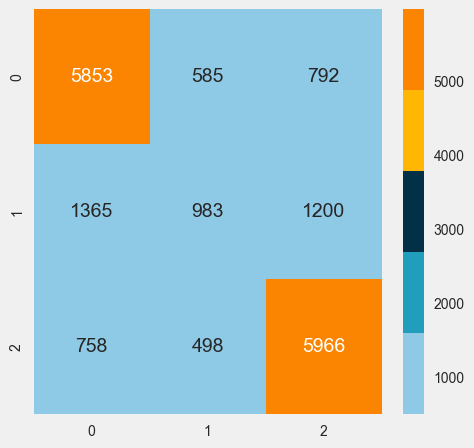

In [54]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test,predictedLogReg), annot=True, fmt="d", cmap=colors)
plt.show()

In [55]:
cm = confusion_matrix(y_test,predictedLogReg)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5853  585  792]
 [1365  983 1200]
 [ 758  498 5966]]

True Positives(TP) =  5853

True Negatives(TN) =  983

False Positives(FP) =  585

False Negatives(FN) =  1365


In [56]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [57]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy of LG: {0:0.4f}'.format(classification_accuracy))

Classification accuracy of LG: 0.7781


In [58]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error of LG: {0:0.4f}'.format(classification_error))

Classification error of LG: 0.2219


In [59]:
precision = TP / float(TP + FP)
print('Precision of LG: {0:0.4f}'.format(precision))

Precision of LG: 0.9091


In [60]:
recall = TP / float(TP + FN)
print('Recall or Sensitivity of LG: {0:0.4f}'.format(recall))

Recall or Sensitivity of LG: 0.8109


In [61]:
y_pred_prob = logreg.predict_proba(X_test)[0:10]
y_pred_prob

array([[9.13215207e-01, 8.58214765e-02, 9.63316213e-04],
       [7.87778800e-03, 5.21489791e-03, 9.86907314e-01],
       [1.60347103e-02, 2.83782917e-02, 9.55586998e-01],
       [5.39748777e-02, 2.87449719e-01, 6.58575403e-01],
       [6.72490783e-01, 8.80636508e-02, 2.39445566e-01],
       [5.09565168e-02, 1.06660877e-01, 8.42382606e-01],
       [9.39487067e-01, 1.67849414e-02, 4.37279914e-02],
       [7.28382503e-02, 6.77704264e-01, 2.49457485e-01],
       [9.15001127e-01, 5.46394325e-02, 3.03594408e-02],
       [2.14748164e-01, 2.82982975e-01, 5.02268861e-01]])


<li>In each row, the numbers sum to 1.</li>
<li>There are 3 columns which correspond to 3 classes - positive, negative, neutral</li>

    predict_proba process:
        Predicts the probabilities --> Choose the class with the highest probability



In [62]:
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - Negative (0)', 'Prob of - Neutral (1)', 'Prob of - Positive (2)'])
y_pred_prob_df

,Prob of - Negative (0),Prob of - Neutral (1),Prob of - Positive (2)
0,0.913215,0.085821,0.000963
1,0.007878,0.005215,0.986907
2,0.016035,0.028378,0.955587
3,0.053975,0.287450,0.658575
4,0.672491,0.088064,0.239446
5,0.050957,0.106661,0.842383
6,0.939487,0.016785,0.043728
7,0.072838,0.677704,0.249457
8,0.915001,0.054639,0.030359
9,0.214748,0.282983,0.502269


### **Training the model using SVM:**

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42, test_size = 0.20)

In [64]:
print(f"Training:\n X = {X_train.shape}\n y = {y_train.shape}")
print(f"Testing:\n X = {X_test.shape}\n y = {y_test.shape}")

Training:
 X = (72000, 5000)
 y = (72000,)
Testing:
 X = (18000, 5000)
 y = (18000,)


In [65]:
from sklearn.svm import LinearSVC
svm = LinearSVC()#SVC(kernel="linear")
svm.fit(X_train, y_train)

LinearSVC()

In [66]:
y_pred = svm.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred)*100

70.45555555555556

In [68]:
inp_test = input("Enter review: ")
print(inp_test)

inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)

inp_test = tfidf_vectorizer.transform([inp_test])
svm.predict(inp_test)

While the product arrived earlier than expected and the packaging was impressive, the actual build quality left much to be desired, especially considering the premium price point — I found myself both impressed by the service and disappointed by the performance.
After preprocessing:  product arrived earlier expected packaging impressive actual build quality left much desired especially considering premium price point found impressed service disappointed performance


array(['Negative'], dtype=object)

#### **Model Analysis:**

In [69]:
# classification_report and accuracy_score using sklearn.metrics library
print("Classification Report")
print(f"{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.72      0.81      0.76      7230
     Neutral       0.47      0.24      0.32      3548
    Positive       0.74      0.83      0.78      7222

    accuracy                           0.70     18000
   macro avg       0.64      0.63      0.62     18000
weighted avg       0.68      0.70      0.68     18000

Accuracy: 0.7045555555555556


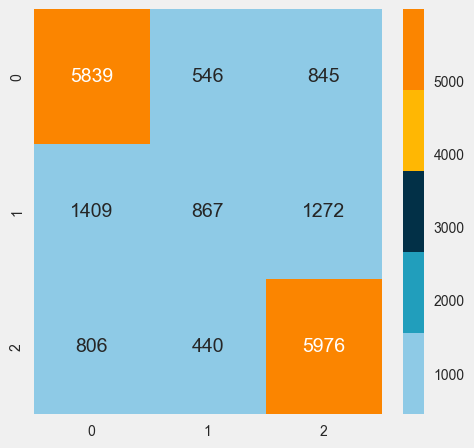

In [70]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap=colors)
plt.show()

In [71]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5839  546  845]
 [1409  867 1272]
 [ 806  440 5976]]

True Positives(TP) =  5839

True Negatives(TN) =  867

False Positives(FP) =  546

False Negatives(FN) =  1409


In [72]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [73]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy of SVM: {0:0.4f}'.format(classification_accuracy))

Classification accuracy of SVM: 0.7743


In [74]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error of SVM: {0:0.4f}'.format(classification_error))

Classification error of SVM: 0.2257


In [75]:
precision = TP / float(TP + FP)
print('Precision of SVM: {0:0.4f}'.format(precision))

Precision of SVM: 0.9145


In [76]:
recall = TP / float(TP + FN)
print('Recall or Sensitivity of SVM: {0:0.4f}'.format(recall))

Recall or Sensitivity of SVM: 0.8056


#### **Exporting the models as a pickled file:**

In [77]:
pi = {'vectorizer': tfidf_vectorizer, 'logreg': logreg, 'svm': svm}
pickle.dump(pi, open('models' + '.p', 'wb'))